In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import pandas_datareader.data as web

import itertools
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update(plt.rcParamsDefault)
#plt.style.use('fivethirtyeight')


This dataset contains simulated time series data covering 10 years (2010-2019). The features include date, store id, product id and number sold. The train.csv covers the years 2010-2018 and the test.csv covers 2019 only. The are 7 unique stores and 10 unique products. The are no null values. The objective is to predict the number sold feature in the test.csv.

I created this time series data using multiple features including various long term trends, year-long seasonality patterns, weekday/weekend effects and noise. Moreover, the products and the stores are supposed to be weakly correlated.

In [13]:
train = pd.read_csv('trainnnnn.csv',header=[0])
test = pd.read_csv('testttttt.csv',header=[0])

df = pd.concat([train, test],ignore_index=True)

In [14]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [15]:
new_df = df[(df['store']==0) & (df['product']==0)]
new_df = new_df.drop(columns=['store','product'],axis=1)

In [16]:
new_df = new_df['number_sold'].resample('15D').mean()

In [17]:
#new_df = new_df['2018-01-01':]

In [18]:
train = new_df[:'2018-12-31']
test = new_df['2019-01-01':]

In [19]:
new_df.plot(figsize=(15,6))

<AxesSubplot:xlabel='Date'>

In [20]:
new_df.hist()

<AxesSubplot:xlabel='Date'>

In [21]:
new_df

Date
2010-01-01    817.666667
2010-01-16    828.733333
2010-01-31    840.533333
2010-02-15    850.000000
2010-03-02    862.133333
                 ...    
2019-10-26    815.733333
2019-11-10    816.933333
2019-11-25    830.266667
2019-12-10    845.933333
2019-12-25    855.857143
Freq: 15D, Name: number_sold, Length: 244, dtype: float64

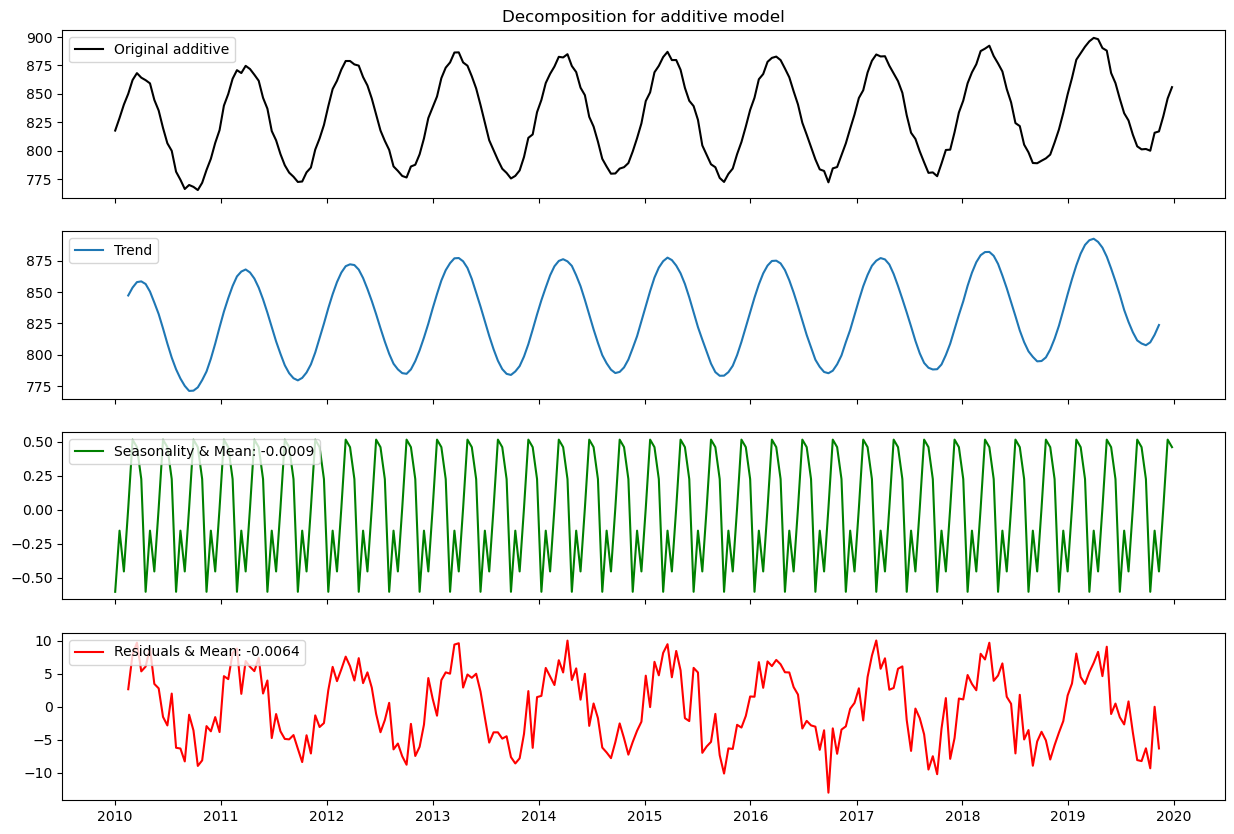

Result: Non-Stationary (H0: non-stationary, p-value: 0.929)


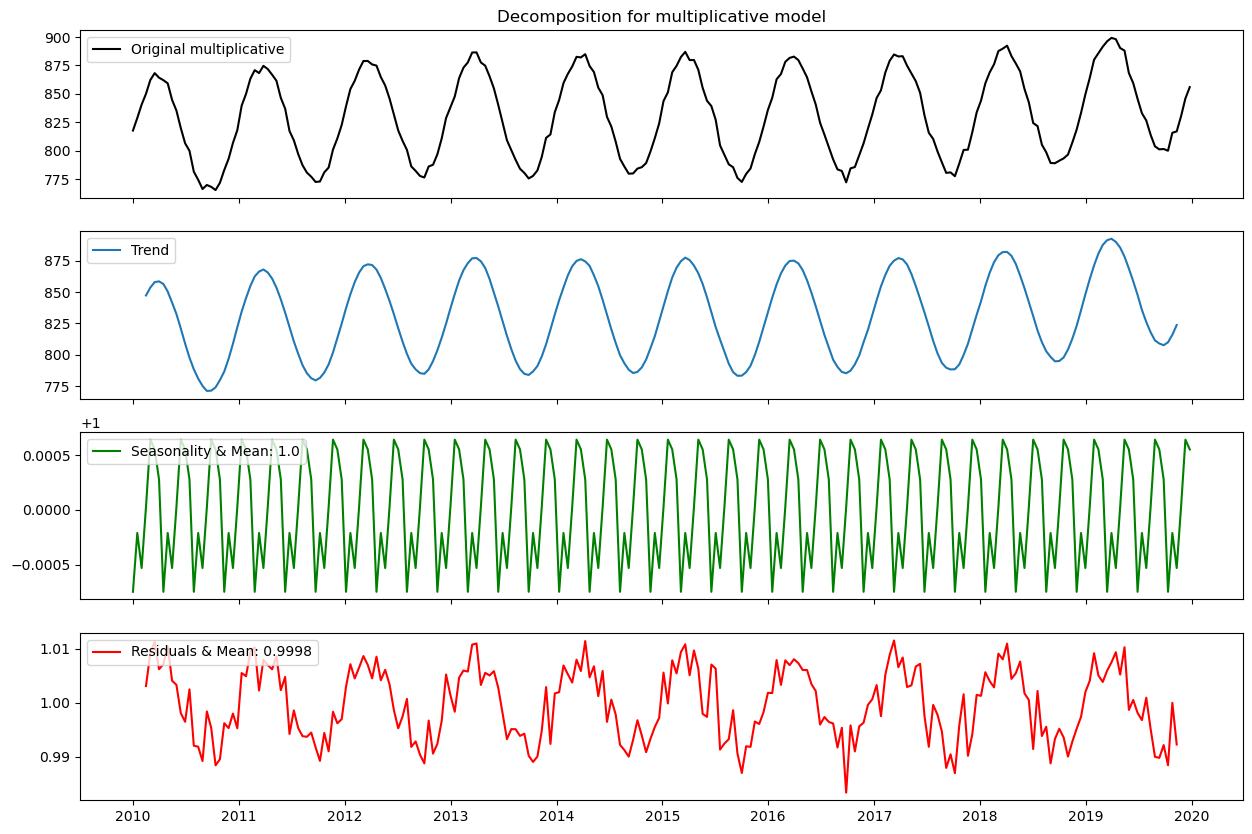

Result: Non-Stationary (H0: non-stationary, p-value: 0.929)


In [35]:
def ts_decompose(data, model="additive", stationary=False):
    result = seasonal_decompose(data, model=model)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(data, 'k', label='Original ' + model)
    axes[0].legend(loc='upper left')

    axes[1].plot(result.trend, label='Trend')
    axes[1].legend(loc='upper left')

    axes[2].plot(result.seasonal, 'g', label='Seasonality & Mean: ' + str(round(result.seasonal.mean(), 4)))
    axes[2].legend(loc='upper left')

    axes[3].plot(result.resid, 'r', label='Residuals & Mean: ' + str(round(result.resid.mean(), 4)))
    axes[3].legend(loc='upper left')
    plt.show(block=True)

    if stationary:
        is_stationary(data)
        
for model in ["additive", "multiplicative"]:
    ts_decompose(new_df, model, stationary=True)

### Augmented Dickey-Fuller Test
Statistical tests make strong assumptions about your data. They can only be used to inform the degree to which a null hypothesis can be rejected or fail to be rejected. The result must be interpreted for a given problem to be meaningful.

However, they provide a quick check and confirmatory evidence that the time series is stationary or non-stationary.

ADF test is conducted with the following assumptions.

**Null Hypothesis (HO)**: Series is non-stationary or series has a unit root.<br>
**Alternate Hypothesis(HA)**: Series is stationary or series has no unit root.

In [23]:
def is_stationary(data):

    # "HO: Non-stationary"
    # "H1: Stationary"

    p_value = sm.tsa.stattools.adfuller(data)[1]
    if p_value < 0.05:
        print(F"Result: Stationary (H1: stationary, p-value: {round(p_value, 3)})")
    else:
        print(F"Result: Non-Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")


is_stationary(new_df)

Result: Non-Stationary (H0: non-stationary, p-value: 0.929)


### SMOOTHING METHODS
##### 1) Moving Average

Moving averages can smooth time series data, reveal underlying trends, and identify components for use in statistical modeling. Smoothing is the process of removing random variations that appear as coarseness in a plot of raw time series data. It reduces the noise to emphasize the signal that can contain trends and cycles. Analysts also refer to the smoothing process as filtering the data.

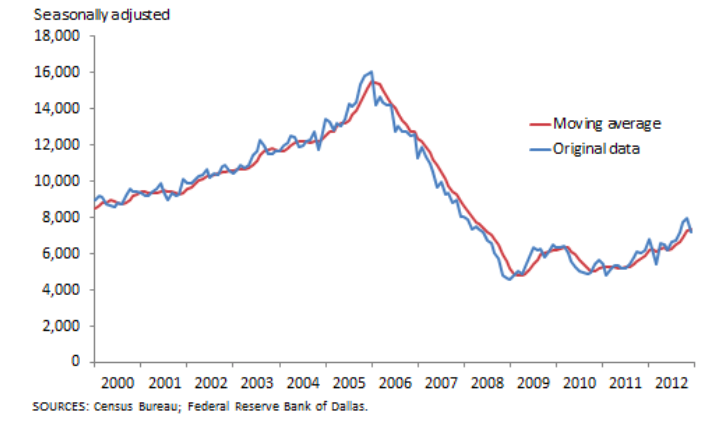

##### 2) Simple Exponential Smoothing

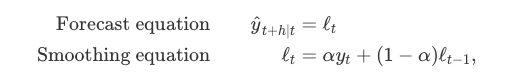

Single Exponential Smoothing, SES for short, also called Simple Exponential Smoothing, is a time series forecasting method for univariate data without a trend or seasonality.

It requires a single parameter, called alpha (a), also called the smoothing factor or smoothing coefficient.

This parameter controls the rate at which the influence of the observations at prior time steps decay exponentially. Alpha is often set to a value between 0 and 1. Large values mean that the model pays attention mainly to the most recent past observations, whereas smaller values mean more of the history is taken into account when making a prediction.

In [24]:
test

Date
2019-01-14    863.866667
2019-01-29    880.000000
2019-02-13    885.800000
2019-02-28    891.466667
2019-03-15    896.200000
2019-03-30    899.200000
2019-04-14    898.066667
2019-04-29    890.266667
2019-05-14    888.000000
2019-05-29    868.266667
2019-06-13    859.400000
2019-06-28    845.600000
2019-07-13    832.933333
2019-07-28    826.533333
2019-08-12    814.000000
2019-08-27    803.800000
2019-09-11    801.133333
2019-09-26    801.466667
2019-10-11    799.933333
2019-10-26    815.733333
2019-11-10    816.933333
2019-11-25    830.266667
2019-12-10    845.933333
2019-12-25    855.857143
Freq: 15D, Name: number_sold, dtype: float64

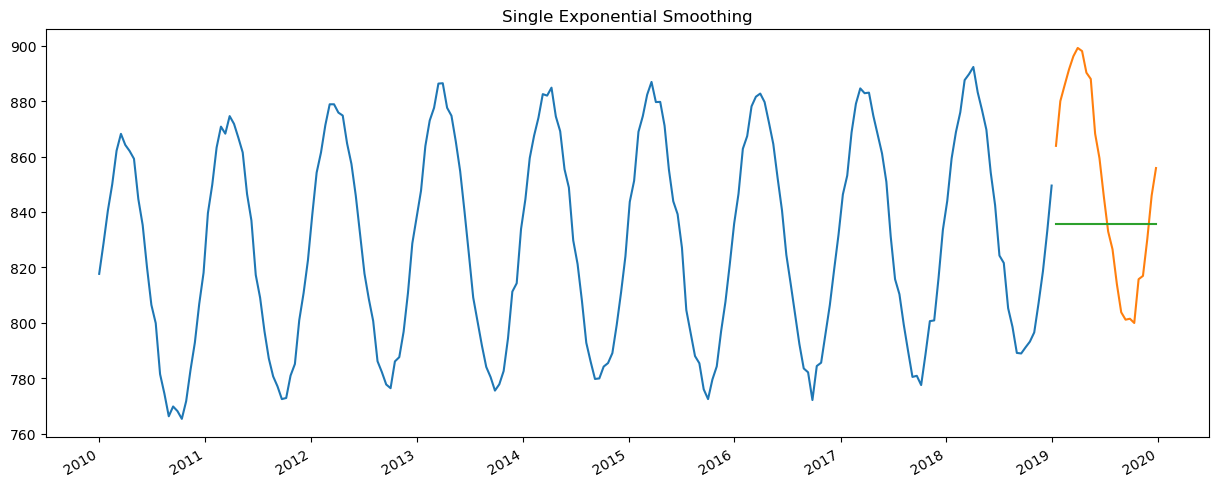

In [25]:
ses_model = SimpleExpSmoothing(train).fit(smoothing_level=0.5)

y_pred = ses_model.forecast(24)

mean_absolute_error(test, y_pred)

plt.figure(figsize=(15,6))
plt.plot(train)
plt.plot(test)
y_pred.plot()
plt.title("Single Exponential Smoothing")
plt.show()

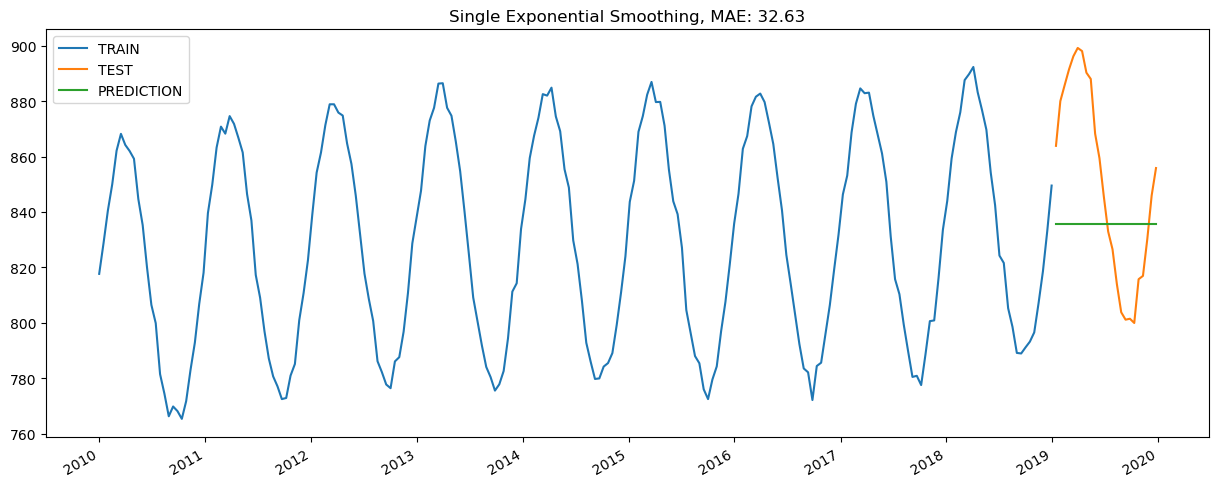

In [26]:
def plot_store0_product0(train, test, y_pred, title):
    mae = mean_absolute_error(test, y_pred)
    plt.figure(figsize=(15,6))
    plt.plot(train)
    plt.plot(test)
    y_pred.plot()
    plt.title(f"{title}, MAE: {round(mae,2)}")
    plt.legend(['TRAIN','TEST','PREDICTION'])
    plt.show()


plot_store0_product0(train, test, y_pred, "Single Exponential Smoothing")

**Hyperparameter Optimization**

In [27]:
def ses_optimizer(train, alphas, step = 24):
    best_alpha, best_mae = None, float("inf")

    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)

        if mae < best_mae:
            best_alpha, best_mae = alpha, mae
        
        print("alpha:", round(alpha, 2), "mae:", round(mae, 4))

    print("best_alpha:", round(best_alpha, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_mae

alphas = np.arange(0.05, 1, 0.01)
ses_optimizer(train, alphas)

best_alpha, best_mae = ses_optimizer(train, alphas)

alpha: 0.05 mae: 34.5578
alpha: 0.06 mae: 34.8927
alpha: 0.07 mae: 35.293
alpha: 0.08 mae: 35.698
alpha: 0.09 mae: 36.0761
alpha: 0.1 mae: 36.4189
alpha: 0.11 mae: 36.7209
alpha: 0.12 mae: 36.9787
alpha: 0.13 mae: 37.1906
alpha: 0.14 mae: 37.3564
alpha: 0.15 mae: 37.4771
alpha: 0.16 mae: 37.5544
alpha: 0.17 mae: 37.5907
alpha: 0.18 mae: 37.5888
alpha: 0.19 mae: 37.5517
alpha: 0.2 mae: 37.4828
alpha: 0.21 mae: 37.3853
alpha: 0.22 mae: 37.2624
alpha: 0.23 mae: 37.1173
alpha: 0.24 mae: 36.9528
alpha: 0.25 mae: 36.7719
alpha: 0.26 mae: 36.5769
alpha: 0.27 mae: 36.3704
alpha: 0.28 mae: 36.1543
alpha: 0.29 mae: 35.9306
alpha: 0.3 mae: 35.7011
alpha: 0.31 mae: 35.4672
alpha: 0.32 mae: 35.2302
alpha: 0.33 mae: 34.9914
alpha: 0.34 mae: 34.7958
alpha: 0.35 mae: 34.604
alpha: 0.36 mae: 34.413
alpha: 0.37 mae: 34.223
alpha: 0.38 mae: 34.0346
alpha: 0.39 mae: 33.8482
alpha: 0.4 mae: 33.6798
alpha: 0.41 mae: 33.5435
alpha: 0.42 mae: 33.4093
alpha: 0.43 mae: 33.2772
alpha: 0.44 mae: 33.1473
alpha: 0.

**Final SES Model**

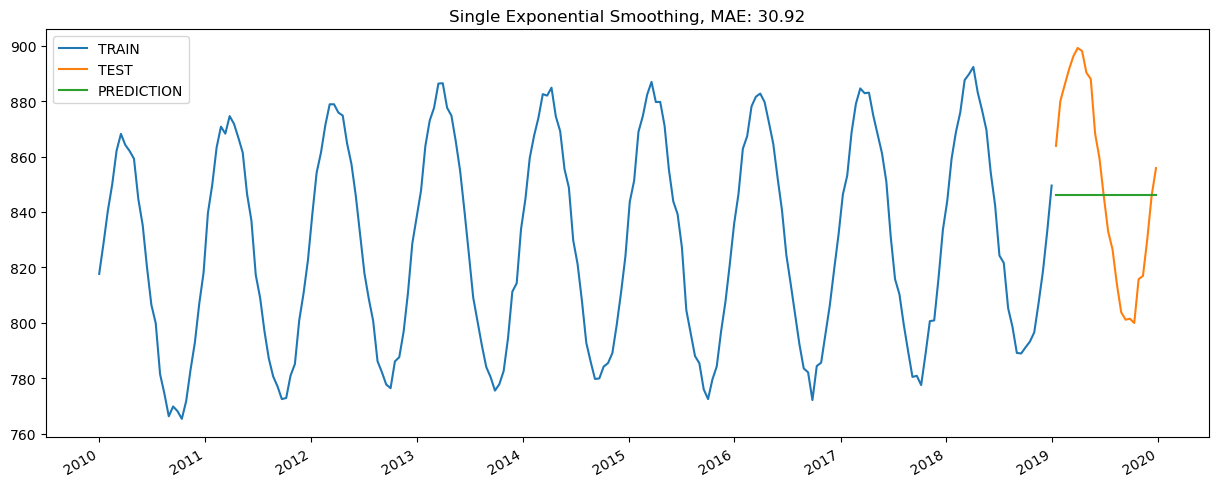

30.92182539682541

In [28]:
ses_model = SimpleExpSmoothing(train).fit(smoothing_level=best_alpha)
y_pred = ses_model.forecast(24)

plot_store0_product0(train, test, y_pred, "Single Exponential Smoothing")
mean_absolute_error(test, y_pred)

##### Double Exponential Smoothing
Double Exponential Smoothing is an extension to Exponential Smoothing that explicitly adds support for trends in the univariate time series.

In addition to the alpha parameter for controlling smoothing factor for the level, an additional smoothing factor is added to control the decay of the influence of the change in trend called beta (b).

The method supports trends that change in different ways: an additive and a multiplicative, depending on whether the trend is linear or exponential respectively.

Double Exponential Smoothing with an additive trend is classically referred to as Holt’s linear trend model, named for the developer of the method Charles Holt.

Additive Trend: Double Exponential Smoothing with a linear trend. Multiplicative Trend: Double Exponential Smoothing with an exponential trend. For longer range (multi-step) forecasts, the trend may continue on unrealistically. As such, it can be useful to dampen the trend over time.

Dampening means reducing the size of the trend over future time steps down to a straight line (no trend).


Additive Dampening: Dampen a trend linearly.

Multiplicative Dampening: Dampen the trend exponentially.

**Hyperparameters:**

Alpha: Smoothing factor for the level.

Beta: Smoothing factor for the trend.

Trend Type: Additive or multiplicative.

Dampen Type: Additive or multiplicative.

Phi: Damping coefficient.



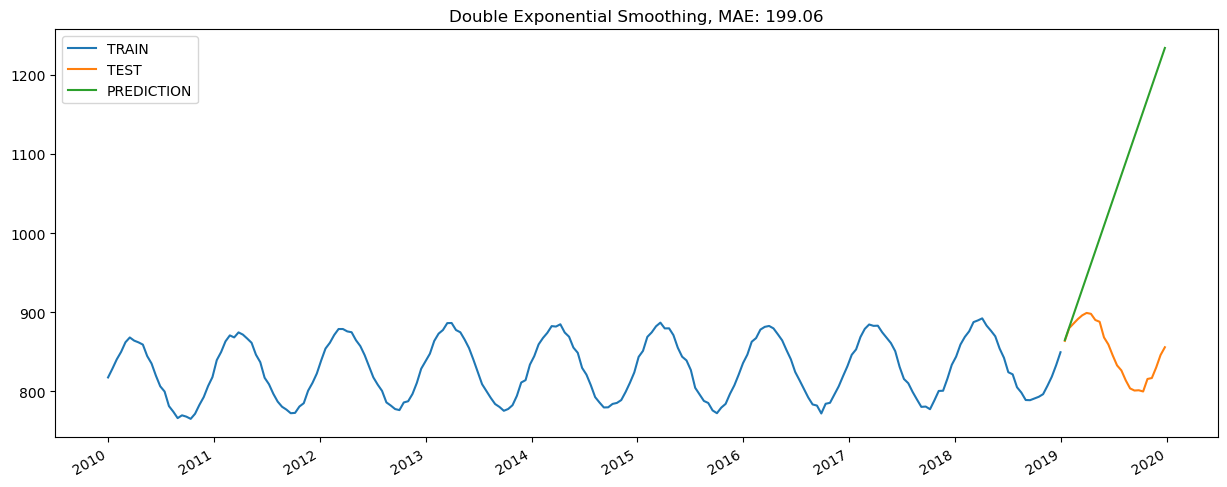

{'smoothing_level': 0.8,
 'smoothing_trend': 0.8,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 806.1214651952381,
 'initial_trend': 11.453814283168354,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [29]:
des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=0.8,
                                                         smoothing_trend=0.8)

y_pred = des_model.forecast(24)

plot_store0_product0(train, test, y_pred, "Double Exponential Smoothing")

des_model.params

**Hyperparameter Optimization**

In [30]:
def des_optimizer(train, alphas, betas, step=24):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=alpha,
                                                                     smoothing_slope=beta)
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
            print("alpha:", round(alpha, 2), "beta:", round(beta, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_beta, best_mae


alphas = np.arange(0.01, 1, 0.10)
betas = np.arange(0.01, 1, 0.10)

best_alpha, best_beta, best_mae = des_optimizer(train, alphas, betas)

alpha: 0.01 beta: 0.01 mae: 33.1098
alpha: 0.01 beta: 0.11 mae: 33.5118
alpha: 0.01 beta: 0.21 mae: 32.6585
alpha: 0.01 beta: 0.31 mae: 31.4664
alpha: 0.01 beta: 0.41 mae: 31.8853
alpha: 0.01 beta: 0.51 mae: 32.5884
alpha: 0.01 beta: 0.61 mae: 31.9915
alpha: 0.01 beta: 0.71 mae: 32.1164
alpha: 0.01 beta: 0.81 mae: 35.3676
alpha: 0.01 beta: 0.91 mae: 39.4894
alpha: 0.11 beta: 0.01 mae: 36.9651
alpha: 0.11 beta: 0.11 mae: 56.1374
alpha: 0.11 beta: 0.21 mae: 94.1358
alpha: 0.11 beta: 0.31 mae: 134.8833
alpha: 0.11 beta: 0.41 mae: 155.6351
alpha: 0.11 beta: 0.51 mae: 102.715
alpha: 0.11 beta: 0.61 mae: 111.5683
alpha: 0.11 beta: 0.71 mae: 220.0698
alpha: 0.11 beta: 0.81 mae: 283.6545
alpha: 0.11 beta: 0.91 mae: 302.9102
alpha: 0.21 beta: 0.01 mae: 37.9275
alpha: 0.21 beta: 0.11 mae: 57.7436
alpha: 0.21 beta: 0.21 mae: 52.7911
alpha: 0.21 beta: 0.31 mae: 67.1538
alpha: 0.21 beta: 0.41 mae: 134.968
alpha: 0.21 beta: 0.51 mae: 187.2496
alpha: 0.21 beta: 0.61 mae: 210.8814
alpha: 0.21 beta: 0.

**Final SES Model**

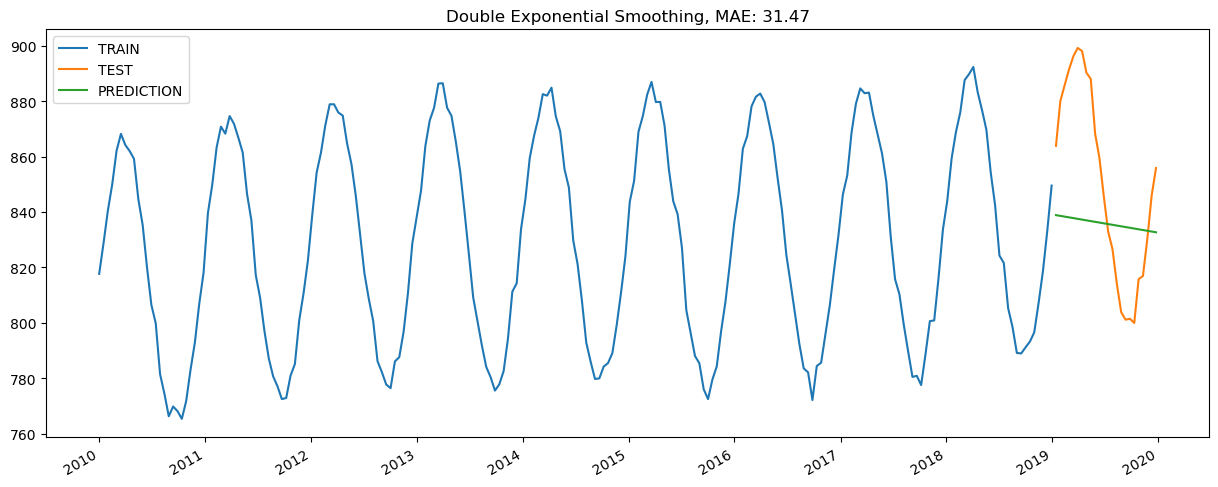

In [31]:
final_des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=best_alpha,
                                                               smoothing_slope=best_beta)

y_pred = final_des_model.forecast(24)

plot_store0_product0(train, test, y_pred, "Double Exponential Smoothing")

##### Triple Exponential Smoothing Holt-Witers

Triple Exponential Smoothing is an extension of Exponential Smoothing that explicitly adds support for seasonality to the univariate time series.

This method is sometimes called Holt-Winters Exponential Smoothing, named for two contributors to the method: Charles Holt and Peter Winters.

In addition to the alpha and beta smoothing factors, a new parameter is added called gamma (g) that controls the influence on the seasonal component.

As with the trend, the seasonality may be modeled as either an additive or multiplicative process for a linear or exponential change in the seasonality.

Additive Seasonality: Triple Exponential Smoothing with a linear seasonality.

Multiplicative Seasonality: Triple Exponential Smoothing with an exponential seasonality.

Triple exponential smoothing is the most advanced variation of exponential smoothing and through configuration, it can also develop double and single exponential smoothing models.

**Additive Method Components:**

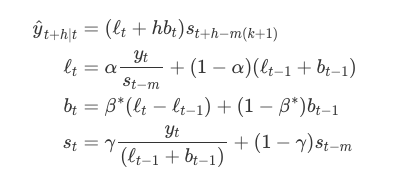

**Multiplicative Method Components:**

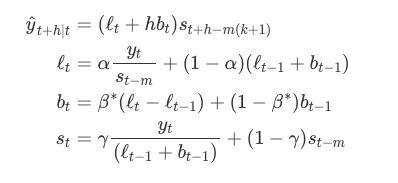

**Hyperparameters:**

Alpha: Smoothing factor for the level.

Beta: Smoothing factor for the trend.

Gamma: Smoothing factor for the seasonality.

Trend Type: Additive or multiplicative.

Dampen Type: Additive or multiplicative.

Phi: Damping coefficient.

Seasonality Type: Additive or multiplicative.

Period: Time steps in seasonal period.

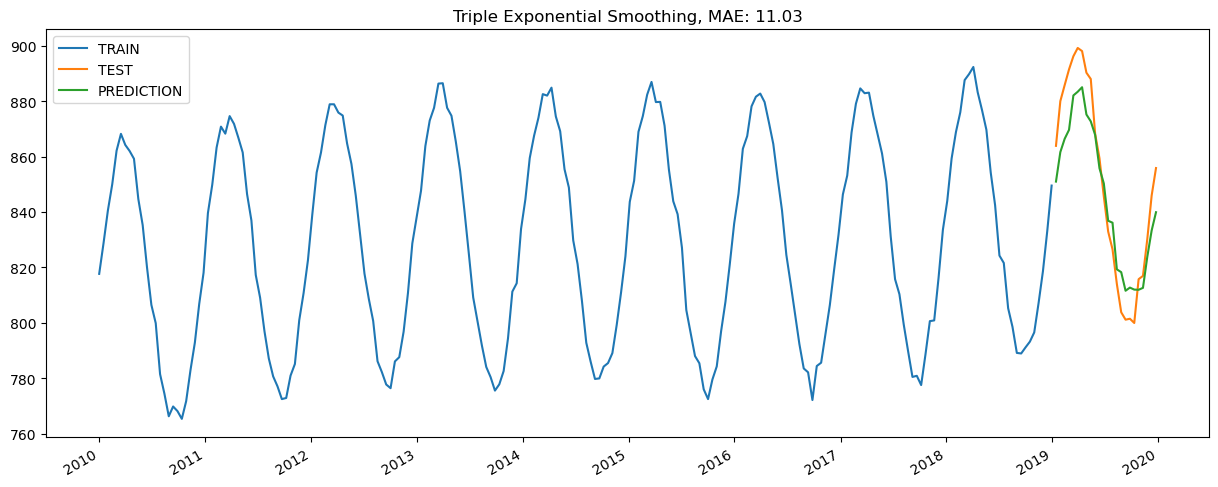

In [32]:
tes_model = ExponentialSmoothing(train,
                                 #trend="add",
                                 seasonal="add",
                                 seasonal_periods=25).fit(smoothing_level=0.5,
                                                          smoothing_slope=0.5,
                                                          smoothing_seasonal=0.9)


y_pred = tes_model.forecast(24)

plot_store0_product0(train, test, y_pred, "Triple Exponential Smoothing")

**Hyperparameter Optimization**

In [33]:
def tes_optimizer(train, abg, step=24):
    best_alpha, best_beta, best_gamma, best_mae, best_seasonal_periods = None, None, None, float("inf"), float("inf")

    for comb in abg:
        for i in range(2,50):
            tes_model = ExponentialSmoothing(train, seasonal="add", seasonal_periods=i).\
                fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
            y_pred = tes_model.forecast(step)

            mae = mean_absolute_error(test, y_pred)
            
            if mae < best_mae:
                best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
                best_seasonal_periods = i
            print([round(comb[0], 2), round(comb[1], 2), round(comb[2], 2), round(mae, 2)], best_seasonal_periods)

    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae


alphas = betas = gammas = np.arange(0.10, 1, 0.15)
abg = list(itertools.product(alphas, betas, gammas))


best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, abg)

[0.1, 0.1, 0.1, 38.37] 2
[0.1, 0.1, 0.1, 37.77] 3
[0.1, 0.1, 0.1, 37.57] 4
[0.1, 0.1, 0.1, 37.38] 5
[0.1, 0.1, 0.1, 37.34] 6
[0.1, 0.1, 0.1, 37.34] 6
[0.1, 0.1, 0.1, 37.14] 8
[0.1, 0.1, 0.1, 37.36] 8
[0.1, 0.1, 0.1, 37.66] 8
[0.1, 0.1, 0.1, 37.67] 8
[0.1, 0.1, 0.1, 36.9] 12
[0.1, 0.1, 0.1, 36.74] 13
[0.1, 0.1, 0.1, 36.85] 13
[0.1, 0.1, 0.1, 37.38] 13
[0.1, 0.1, 0.1, 38.16] 13
[0.1, 0.1, 0.1, 38.69] 13
[0.1, 0.1, 0.1, 37.86] 13
[0.1, 0.1, 0.1, 40.22] 13
[0.1, 0.1, 0.1, 40.76] 13
[0.1, 0.1, 0.1, 40.06] 13
[0.1, 0.1, 0.1, 43.84] 13
[0.1, 0.1, 0.1, 47.68] 13
[0.1, 0.1, 0.1, 17.86] 24
[0.1, 0.1, 0.1, 24.0] 24
[0.1, 0.1, 0.1, 40.43] 24
[0.1, 0.1, 0.1, 37.63] 24
[0.1, 0.1, 0.1, 32.78] 24
[0.1, 0.1, 0.1, 37.12] 24
[0.1, 0.1, 0.1, 40.98] 24
[0.1, 0.1, 0.1, 37.65] 24
[0.1, 0.1, 0.1, 35.99] 24
[0.1, 0.1, 0.1, 37.38] 24
[0.1, 0.1, 0.1, 40.32] 24
[0.1, 0.1, 0.1, 41.9] 24
[0.1, 0.1, 0.1, 38.08] 24
[0.1, 0.1, 0.1, 39.03] 24
[0.1, 0.1, 0.1, 38.91] 24
[0.1, 0.1, 0.1, 36.96] 24
[0.1, 0.1, 0.1, 41.2] 24


**Final TES Model**

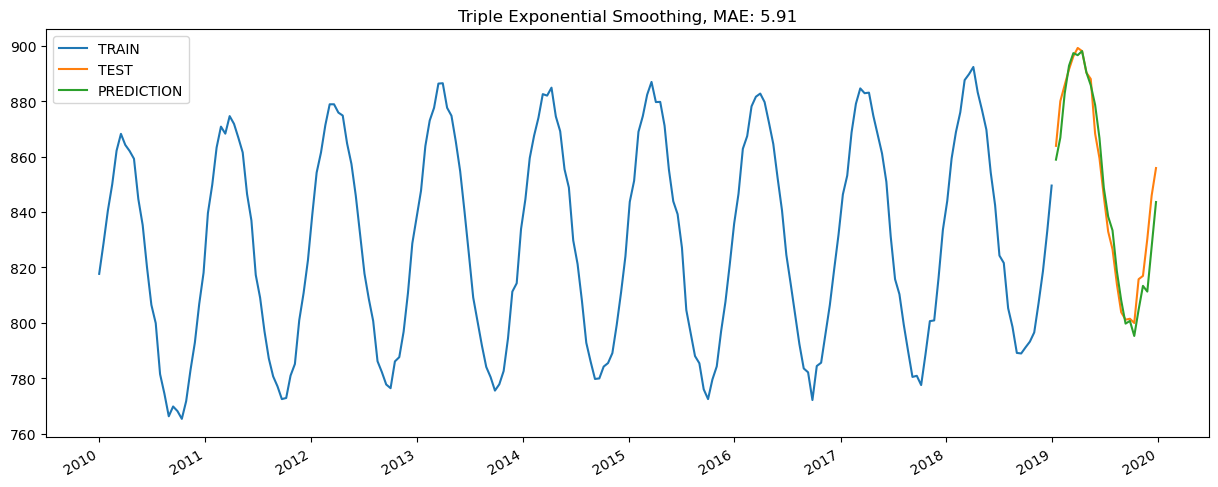

In [34]:
final_tes_model = ExponentialSmoothing(train,
                                         #trend="add", 
                                         seasonal="add", 
                                         seasonal_periods=49).\
            fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)

y_pred = final_tes_model.forecast(24)

plot_store0_product0(train, test, y_pred, "Triple Exponential Smoothing")